# Convenience module for pytorch training

## Imports

In [1]:
import writefile_run

In [2]:
%%writefile_run train_utils.py


"""
Concenvience module for pytorch training and visualization.
"""

import torch
import torch.nn as nn
from torch import optim
from pylab import *
from torch.utils.data import *
from IPython import display
import os

style.use(['dark_background'])
rcParams['axes.grid']=True

In [3]:
import torch.nn.functional as F

# Setup a model for MNIST to demo the module

## Get the data

In [4]:
from torchvision.datasets import *
from torchvision.transforms import *

In [5]:
train_mnist = MNIST('/MNIST',download=True,transform=ToTensor())
test_mnist = MNIST('/MNIST',train=False,transform=ToTensor())

In [6]:
train_loader = DataLoader(train_mnist, batch_size=32,shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=32,shuffle=True)

## The model

In [7]:
class MnistClassifier(nn.Module):
    def __init__(self, hid_size):
        super(MnistClassifier, self).__init__()
        
        self.hidden_layer = nn.Linear(28*28,hid_size)
        
        self.output_layer = nn.Linear(hid_size,10)
        
        
    def forward(self, input):
        input = input.view(-1,28*28)
        
        out = F.relu(self.hidden_layer(input))
        out = self.output_layer(out)
        
        return out

In [8]:
model = MnistClassifier(400)

In [9]:
def getTimeName():
    """Return the current time in format <day>-<month>_<hour><minute> for use in filenames."""
    from datetime import datetime
    t = datetime.now()
    return "{:02d}-{:02d}_{:02d}{:02d}".format(t.day,t.month,t.hour,t.minute)

In [10]:
optimizer = optim.Adam(model.parameters())

In [11]:
def trainOnBatch(model,batch,optimizer):
    outputs = model(batch[0])
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs,batch[1])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [12]:
import sys

In [13]:
epochs = 10000
save_every = 1
save_dir = 'testinglol'

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.2,cooldown=60,patience=30)

''

[                                                            ] 0/1875

FileNotFoundError: [Errno 2] No such file or directory: 'testinglol\\LossPlot.png'

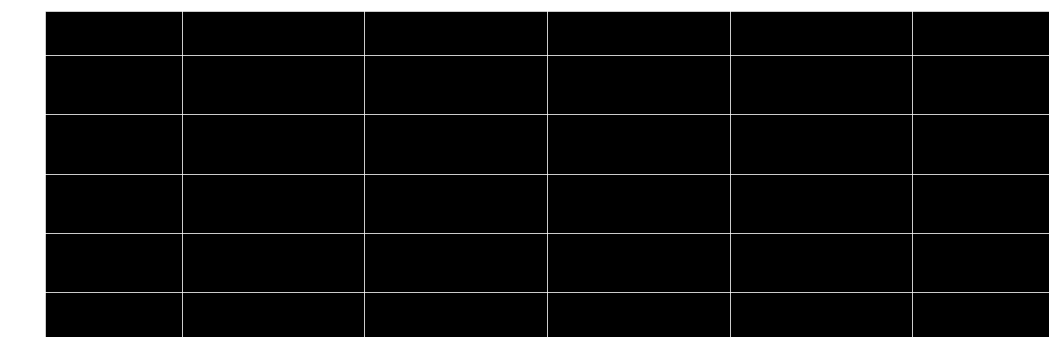

In [14]:
losses = []
loss=0
batch_num=10
gn = 0
d = display.display('', display_id='loss_print')
epoch_progress = display.ProgressBar(len(train_loader))
bar = display.display(epoch_progress,display_id='progress_bar')
fig, ax = subplots(1,1, figsize = (18,6))

loss_line, = ax.plot([1],[0])

plotpath = os.path.join(save_dir,"LossPlot.png")
savefig(plotpath, bbox_inches='tight')

lossplot = display.display(display.Image(plotpath),display_id='loss_plot')
k=0
for e in range(epochs):
    i=0
    grad_norm=0
    for batch in train_loader:
        loss = trainOnBatch(model,batch, optimizer)
        loss = loss.detach().cpu().numpy()
        grad_norm = max(grad_norm, gn)
        i+=1
        if i%batch_num==0:
            k+=1
            toprint = "Epoch {}, batch {}, lr={:.6f}, loss={:.5f}".format(e+1,i,
                                optimizer.state_dict()['param_groups'][0]['lr'],loss)
            disp_obj = display.Markdown(toprint)
            d.update(disp_obj)
            epoch_progress.progress = i
            bar.update(epoch_progress)
            #plot(losses)
            #show()
            losses.append(loss)
        #     ax.set_xlim(0,e+2)
        #     ax.set_ylim(0,max(losses)*1.2)

            loss_line.set_xdata(arange(k)+1)
            loss_line.set_ydata(losses)


            ax.relim()
            ax.autoscale()
            xl,xr = ax.get_xlim()
            ax.set_xlim((0,None))
        #     ax.set_xlim(0,4.6)

            yl,yr = ax.get_ylim()
            ax.set_ylim(0,yr)

            savefig(plotpath, bbox_inches='tight')

            lossplot.update(display.Image(plotpath))
 
   
    scheduler.step(loss)
   
    
    
    if e%(save_every)==0:
        print("Saving model at {}".format(getTimeName()))
        torch.save(model.state_dict(), 
                   os.path.join(save_dir,"{}_epoch{:03d}_loss_{:.5f}".format(getTimeName(),e+1,loss)))
        
    print(loss)